In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns
import pickle
from cpymad.madx import Madx
from pybt.tools.plotters import *
from madxtools.plot_tool import *
from madxtools.air_scattering import *
import requests

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [67]:
with open('MWPC_RP_run.pickle', 'rb') as f:
    data = pickle.load(f)

with open('Quadrupoles_RP_run.pickle', 'rb') as f:
    df_quadrupoles = pickle.load(f)

In [68]:
df_quadrupoles.keys()

Index(['timestamp', 'selector', 'avg_flattop_Gauss', 'Ekin', 'Brho', 'current',
       'magnet_name', 'type', 'k1'],
      dtype='object')

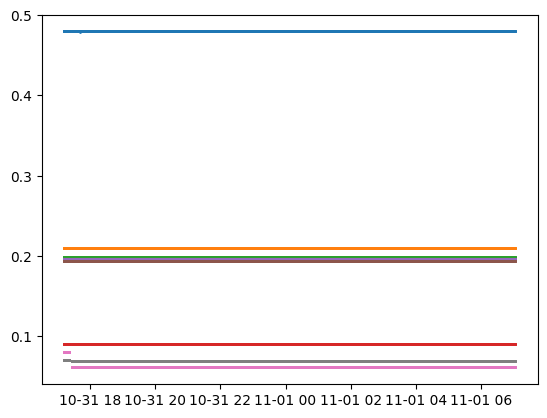

In [69]:
keys = ["F61.QFN007/MEAS.PULSE",
           "F61.QDN014/MEAS.PULSE",
           "F61.QFN021/MEAS.PULSE",
           "F61.QDN030/MEAS.PULSE",
           "T08.QFN021/MEAS.PULSE",
           "T08.QDN023/MEAS.PULSE",
           "T08.QDN061/MEAS.PULSE",
           "T08.QFN066/MEAS.PULSE"]


fig, ax = plt.subplots()
for key in keys:

    k1 = df_quadrupoles[df_quadrupoles.magnet_name == key].k1
    timestamp = df_quadrupoles[df_quadrupoles.magnet_name == key].timestamp

    ax.scatter(timestamp, k1, s=1)

In [101]:
selector = "CPS.USER.EAST3"
target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')

keys = ["F61.QFN007/MEAS.PULSE",
           "F61.QDN014/MEAS.PULSE",
           "F61.QFN021/MEAS.PULSE",
           "F61.QDN030/MEAS.PULSE",
           "T08.QFN021/MEAS.PULSE",
           "T08.QDN023/MEAS.PULSE",
           "T08.QDN061/MEAS.PULSE",
           "T08.QFN066/MEAS.PULSE"]

quad_k1_at_targ_t = []
for key in keys:
    print(key)
    df_quadrupoles_key = df_quadrupoles[df_quadrupoles.magnet_name == key]

    differences = (df_quadrupoles_key[df_quadrupoles_key.selector == selector].timestamp - target_timestamp).abs()
    closest_index = differences.idxmin()
    element = closest_index

    print(df_quadrupoles_key.magnet_name.loc[element])
    print(df_quadrupoles_key.timestamp.loc[element])
    print(df_quadrupoles_key.k1.loc[element])
    quad_k1_at_targ_t.append(df_quadrupoles_key.k1.loc[element])
    print("")
print(quad_k1_at_targ_t)

F61.QFN007/MEAS.PULSE
F61.QFN007/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.4795819874090377

F61.QDN014/MEAS.PULSE
F61.QDN014/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.2099961145921118

F61.QFN021/MEAS.PULSE
F61.QFN021/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.1986350277984894

F61.QDN030/MEAS.PULSE
F61.QDN030/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.0903378221301109

T08.QFN021/MEAS.PULSE
T08.QFN021/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.19619654081203947

T08.QDN023/MEAS.PULSE
T08.QDN023/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.19446393907335138

T08.QDN061/MEAS.PULSE
T08.QDN061/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.061373387487676664

T08.QFN066/MEAS.PULSE
T08.QFN066/MEAS.PULSE
2023-10-31 18:45:00.698238525
0.06905470641595324

[0.4795819874090377, 0.2099961145921118, 0.1986350277984894, 0.0903378221301109, 0.19619654081203947, 0.19446393907335138, 0.061373387487676664, 0.06905470641595324]


# MAD-X T8 with air

In [102]:
E_cin_per_nucleon = 3.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

print(p/charge)
print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p/charge,3)} GeV/c")

Brho = 3.33564*p/charge

14.712151687490184
gamma = 15.685
beta = 0.998
p = 14.712 GeV/c


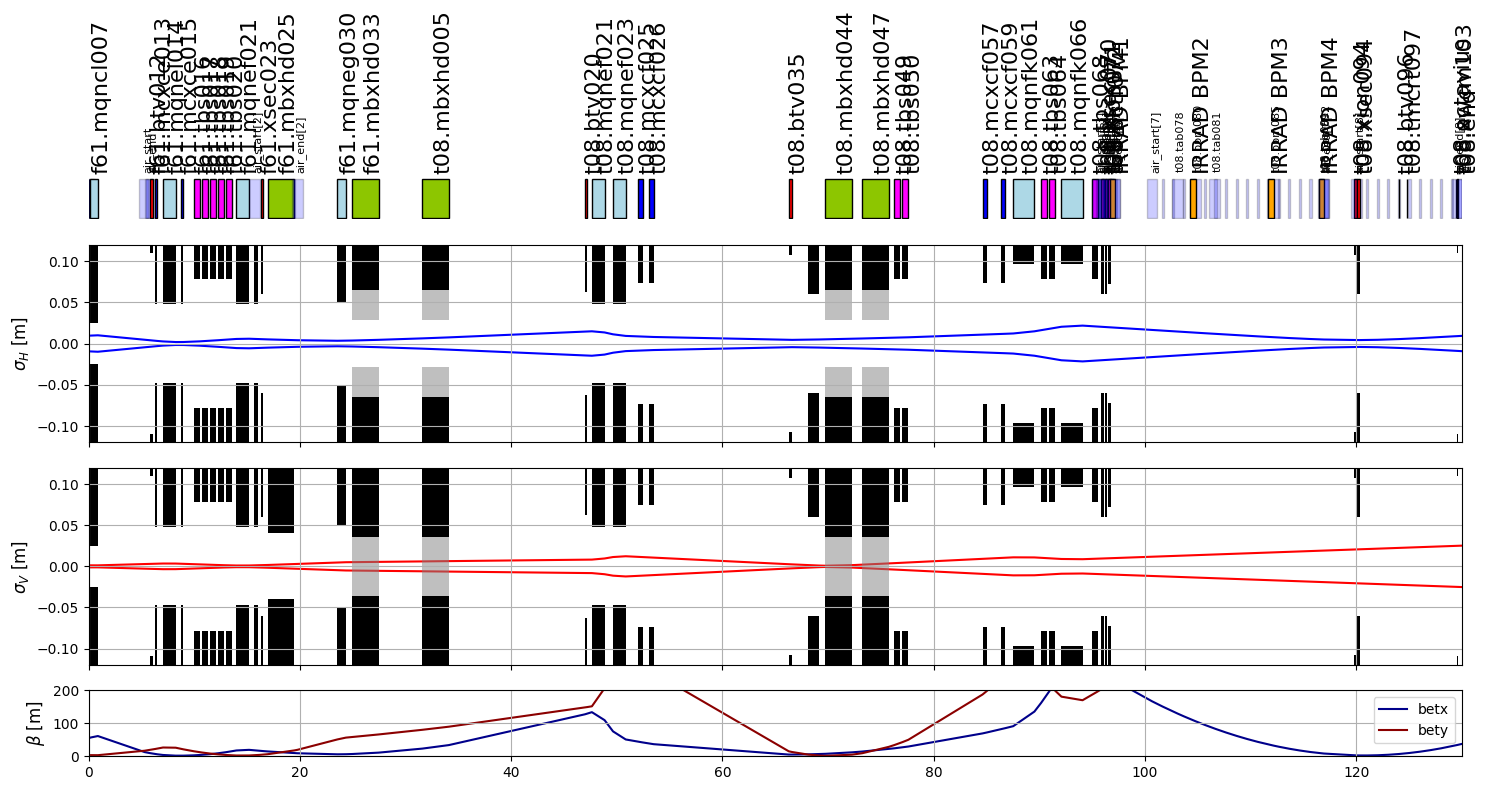

In [127]:
# Matched initial parameters 13nd oct 2023
betx0 = 53.074
alfx0 = -13.191
Dx0 = 0.13
Dpx0 = 0.02
exn = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
Dy0 = 0.0
Dpy0 = 0.0
eyn = 6.94e-06

sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)


# Quadrupoles
madx.input("kQFN1 = "+str(quad_k1_at_targ_t[0])+";")
madx.input("kQDN2 = "+str(-quad_k1_at_targ_t[1])+";")
madx.input("kQFN3 = "+str(quad_k1_at_targ_t[2])+";")
madx.input("kQDN4 = "+str(-quad_k1_at_targ_t[3])+";")
madx.input("kQFN5 = "+str(quad_k1_at_targ_t[4])+";")
madx.input("kQDN6 = "+str(-quad_k1_at_targ_t[5])+";")
madx.input("kQDN7 = "+str(-quad_k1_at_targ_t[6])+";")
madx.input("kQFN8 = "+str(quad_k1_at_targ_t[7])+";")

# Dipoles
madx.input("kBHZ1 = "+str(-0.04821227494)+";")
madx.input("kBHZ2 = "+str(0.04980753404)+";")
madx.input("kBHZ3 = "+str(0.02555487086)+";")
madx.input("kBHZ4 = "+str(-0.03515967369)+";")
madx.input("kBHZ5 = "+str(-0.03515967369)+";")



# Add the Air region
sequence = "f61t8_op"

p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

#t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


# add_hidden_marker(madx, sequence, 20, 100, steps)

madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)

madx.input('''
SEQEDIT, sequence=f61t8_op;
SELECT, FLAG = SEQEDIT, PATTERN = ".*VACC.*";
REMOVE, ELEMENT=SELECTED;
ENDEDIT;
''')

# make thin
madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
# madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")



twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file="RP_run_3GeV.tfs").dframe()

plot_graph(twiss, ex, sige, ey, fontsize=12, figsize=(15,8), height_ratios=[1,3,3,1])

In [104]:
madx.use(sequence=sequence)
madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "t08.end", p/charge, twiss, ex_initial, ey_initial)

In [105]:
twiss.loc['t08.xwcm103']

name       t08.xwcm103:1
keyword          monitor
s             129.659367
betx           34.950309
alfx           -3.645237
               ...      
aper_2               0.0
aper_3               0.0
aper_4               0.0
ex              0.000002
ey                   0.0
Name: t08.xwcm103, Length: 263, dtype: object

In [129]:
twiss_scattered.tail(20)

name     keyword           s  \
t08.vaccum_chamber94     t08.vaccum_chamber94:1  collimator  119.748367   
t08.xion094                       t08.xion094:1     monitor  120.048367   
air_start[8]                        air_start:8      marker  120.048367   
t08.xsec094                       t08.xsec094:1     monitor  120.328367   
inner_marker0_8               inner_marker0_8:1      marker  121.048367   
inner_marker1_8               inner_marker1_8:1      marker  122.048367   
inner_marker2_8               inner_marker2_8:1      marker  123.048367   
inner_marker3_8               inner_marker3_8:1      marker  124.048367   
t08.btv096                         t08.btv096:1     monitor  124.062367   
t08.tmcrt097                     t08.tmcrt097:1  instrument  124.804367   
inner_marker4_8               inner_marker4_8:1      marker  125.048367   
inner_marker5_8               inner_marker5_8:1      marker  126.048367   
inner_marker6_8               inner_marker6_8:1      marker  127.048367   
inner_marker7_8               inner_marker7_8:1      marker  128.048367   
inner_marker8_8               inner_marker8_8:1      marker  129.048367   
t08.octavius                     t08.octavius:1     monitor  129.446867   
air_end[8]                            air_end:8      marker  129.529367   
t08.xwcm103                       t08.xwcm103:1     monitor  129.659367   
t08.end                               t08.end:1  instrument  130.000000   
#e                    seq_air_end8_to_end$end:1      marker  130.000000   

                           betx      alfx       mux        bety      alfy  \
t08.vaccum_chamber94   4.109544  0.062824  0.092110  127.086778 -2.976982   
t08.xion094            4.093836 -0.010465  0.103761  128.879951 -3.000263   
air_start[8]           4.093836 -0.010465  0.103761  128.879951 -3.000263   
t08.xsec094            4.118850 -0.078868  0.114622  130.566183 -3.021993   
inner_marker0_8        4.351152 -0.254731  0.000000  128.372638 -2.928043   
inner_marker1_8        5.094906 -0.498866  0.000000  128.080954 -2.863853   
inner_marker2_8        6.321948 -0.742544  0.000000  127.967804 -2.806376   
inner_marker3_8        8.027036 -0.985233  0.000000  128.004149 -2.754574   
t08.btv096             8.054671 -0.988670  0.000277  128.081290 -2.755513   
t08.tmcrt097           9.657023 -1.170835  0.013683  132.207409 -2.805293   
inner_marker4_8       10.201885 -1.226206  0.000000  128.166919 -2.707618   
inner_marker5_8       12.834316 -1.464560  0.000000  128.437535 -2.664837   
inner_marker6_8       15.907574 -1.699233  0.000000  128.800865 -2.625679   
inner_marker7_8       19.399866 -1.929048  0.000000  129.244451 -2.589690   
inner_marker8_8       23.284171 -2.152744  0.000000  129.757945 -2.556487   
t08.octavius          25.038335 -2.249173  0.002627  131.804688 -2.579630   
air_end[8]            25.283218 -2.257814  0.000000  130.047039 -2.541802   
t08.xwcm103           25.874325 -2.289167  0.000809  130.708877 -2.549260   
t08.end               27.461839 -2.371319  0.002843  132.452256 -2.568802   
#e                    27.461839 -2.371319  0.002843  132.452256 -2.568802   

                           muy    x  ...  sig65  sig66   n1  apertype  aper_1  \
t08.vaccum_chamber94  0.003752  0.0  ...    0.0    0.0  0.0    circle  0.1075   
t08.xion094           0.004125  0.0  ...    0.0    0.0  0.0    circle  0.1075   
air_start[8]          0.004125  0.0  ...    0.0    0.0  0.0    circle  0.0000   
t08.xsec094           0.004469  0.0  ...    0.0    0.0  0.0    circle  0.0600   
inner_marker0_8       0.000000  0.0  ...    0.0    0.0  0.0    circle  0.0000   
inner_marker1_8       0.000000  0.0  ...    0.0    0.0  0.0    circle  0.0000   
inner_marker2_8       0.000000  0.0  ...    0.0    0.0  0.0    circle  0.0000   
inner_marker3_8       0.000000  0.0  ...    0.0    0.0  0.0    circle  0.0000   
t08.btv096            0.000017  0.0  ...    0.0    0.0  0.0    circle  0.0000   
t08.tmcrt097          0.000925  0.0  ..

In [118]:
sigH = beam_size(twiss_scattered.loc['t08.xwcm103']['betx'], twiss_scattered.loc['t08.xwcm103']['dx'], twiss_scattered.loc['t08.xwcm103'].ex, sige, 1)
sigV = beam_size(twiss_scattered.loc['t08.xwcm103']['bety'], twiss_scattered.loc['t08.xwcm103']['dy'], twiss_scattered.loc['t08.xwcm103'].ey, sige, 1)

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

fwhmH = fwhm_func(sigH)
fwhmV = fwhm_func(sigV)

print(f"{fwhmH*1000:.2f} mm")
print(f"{fwhmV*1000:.2f} mm")

24.24 mm
62.53 mm


In [130]:
observation = "t08.btv096"
sigH = beam_size(twiss_scattered.loc[observation]['betx'], twiss_scattered.loc[observation]['dx'], twiss_scattered.loc[observation].ex, sige, 1)
sigV = beam_size(twiss_scattered.loc[observation]['bety'], twiss_scattered.loc[observation]['dy'], twiss_scattered.loc[observation].ey, sige, 1)

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

fwhmH = fwhm_func(sigH)
fwhmV = fwhm_func(sigV)

print(f"{fwhmH*1000:.2f} mm")
print(f"{fwhmV*1000:.2f} mm")

15.15 mm
55.76 mm


In [136]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

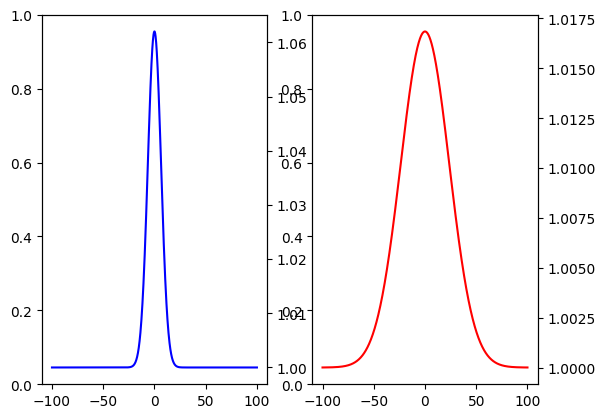

In [137]:
fig, ax = plt.subplots(1,2)
x = np.linspace(-0.1*1000, 0.1*1000, 1000)
ax11 = ax[0].twinx()
ax11.plot(x, gaussian_function(x, 1, 1, 0, sigH*1000), c="b", label="MADX Horizontal")

ax22 = ax[1].twinx()
ax22.plot(x, gaussian_function(x, 1, 1, 0, sigV*1000), c="r", label="MADX Vertical")

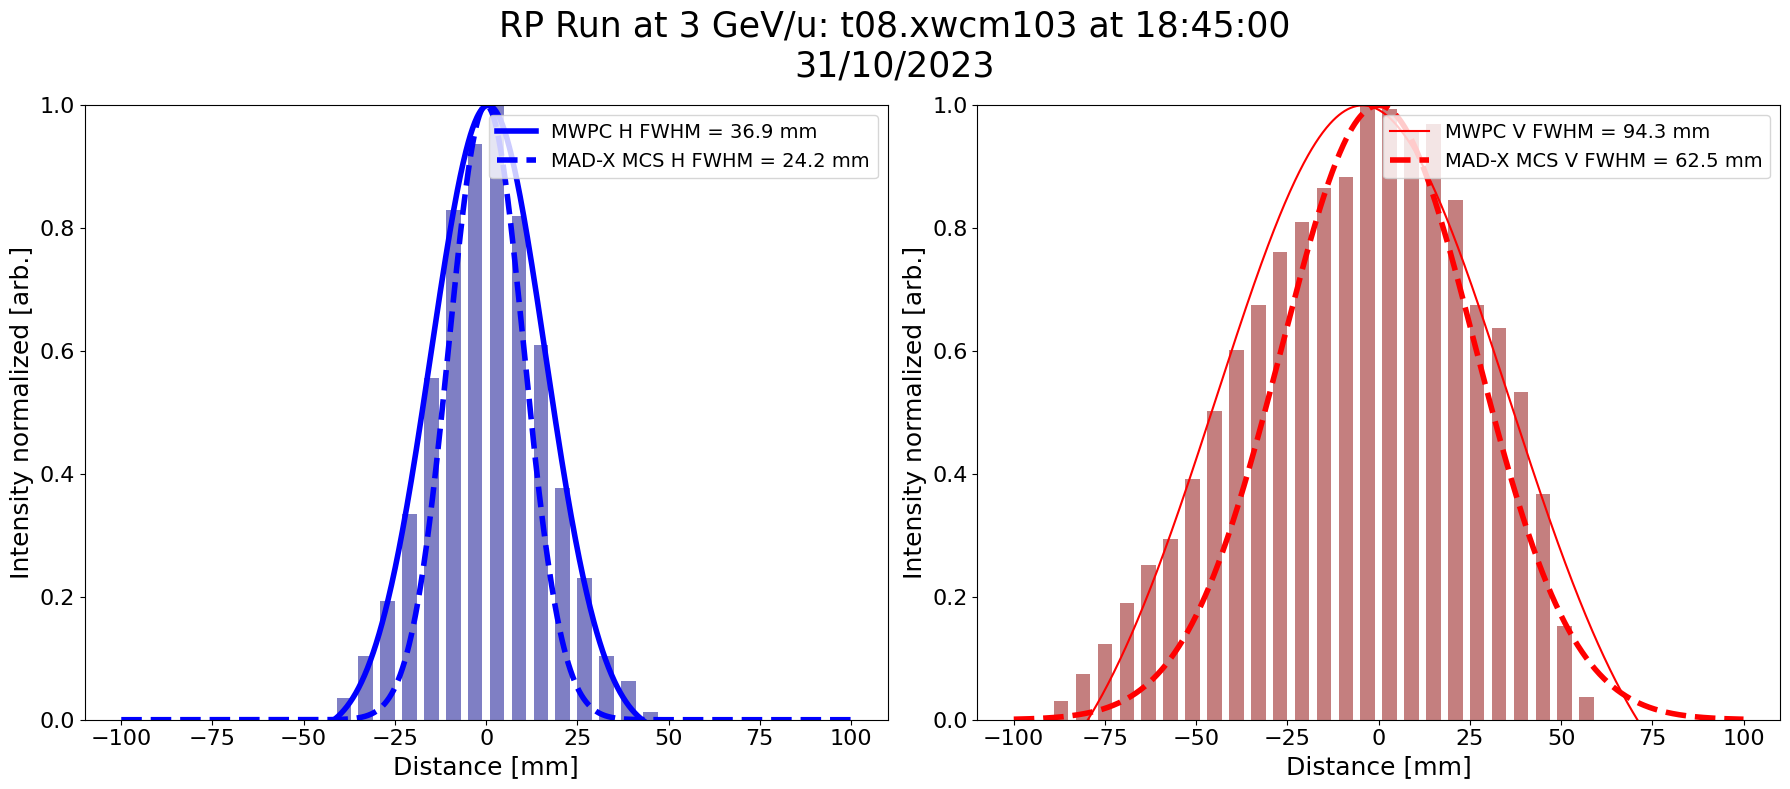

In [208]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit

fig, ax = plt.subplots(1,2, figsize=(18, 8), tight_layout=True)

target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)
x = np.linspace(-0.1*1000, 0.1*1000, 1000)

# Horizontal Measurement and Gaussian Fit
y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
ax[0].bar(MWPC_wire, y/y.max(), width=4, color="darkblue", alpha=0.5)

popt, pcov = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(x, popt[0], popt[1], popt[2], popt[3])
ax[0].plot(x, y_gaussian/y_gaussian.max(), c="b", ls="-", lw=4, label=f"MWPC H FWHM = {fwhm_func(popt[3]):.1f} mm")

# Vertical Measurement and Gaussian Fit
y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
ax[1].bar(MWPC_wire, y/y.max(), width=4, color="darkred", lw=4, alpha=0.5)
poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
ax[1].plot(x, y_gaussian/y_gaussian.max(), c="r", ls="-", label=f"MWPC V FWHM = {fwhm_func(poptV[3]):.1f} mm")

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

# MAD-X
# observation = "t08.btv096"
observation = "t08.xwcm103"
sigH = beam_size(twiss_scattered.loc[observation]['betx'], twiss_scattered.loc[observation]['dx'], twiss_scattered.loc[observation].ex, sige, 1)
sigV = beam_size(twiss_scattered.loc[observation]['bety'], twiss_scattered.loc[observation]['dy'], twiss_scattered.loc[observation].ey, sige, 1)
ax[0].plot(x, gaussian_function(x, 0, 1, 0, sigH*1000)/gaussian_function(x, 0, 1, 0, sigH*1000).max(), lw=4, ls="--", c="b", label=f"MAD-X MCS H FWHM = {fwhm_func(sigH)*1000:.1f} mm")
ax[1].plot(x, gaussian_function(x, 0, 1, 0, sigV*1000)/gaussian_function(x, 0, 1, 0, sigV*1000).max(), lw=4, ls="--", c="r", label=f"MAD-X MCS V FWHM = {fwhm_func(sigV)*1000:.1f} mm")

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

ax[0].set_ylabel("Intensity normalized [arb.]")
ax[1].set_ylabel("Intensity normalized [arb.]")

ax[0].set_xlabel("Distance [mm]")
ax[1].set_xlabel("Distance [mm]")

fig.suptitle(f"RP Run at 3 GeV/u: {observation} at {data[data.selector == selector].timestamp.loc[element].strftime('%H:%M:%S')}\n{data[data.selector == selector].timestamp.loc[element].strftime('%d/%m/%Y')}", fontsize=25)
plt.savefig("3d_mwpc.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

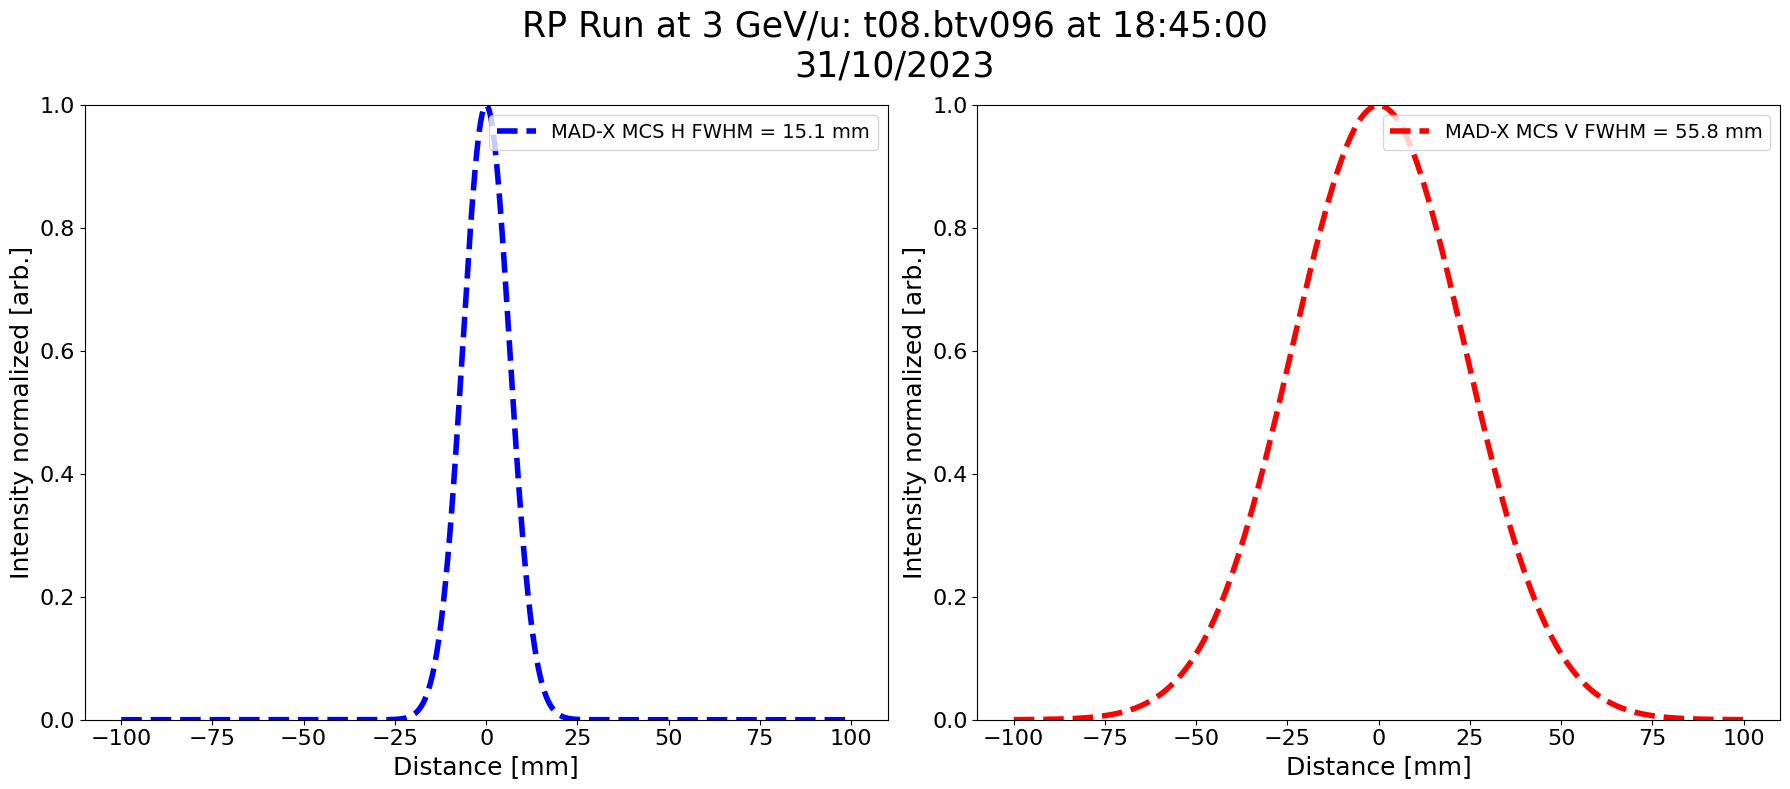

In [207]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit

fig, ax = plt.subplots(1,2, figsize=(18, 8), tight_layout=True)

target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)
x = np.linspace(-0.1*1000, 0.1*1000, 1000)

# # Horizontal Measurement and Gaussian Fit
# y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
# ax[0].bar(MWPC_wire, y/y.max(), width=4, color="darkblue", alpha=0.5)

# popt, pcov = do_gaussian_fit(MWPC_wire, y)
# y_gaussian = gaussian_function(x, popt[0], popt[1], popt[2], popt[3])
# ax[0].plot(x, y_gaussian/y_gaussian.max(), c="b", ls="-", lw=4, label=f"MWPC H FWHM = {fwhm_func(popt[3]):.1f} mm")

# # Vertical Measurement and Gaussian Fit
# y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
# ax[1].bar(MWPC_wire, y/y.max(), width=4, color="darkred", lw=4, alpha=0.5)
# poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
# y_gaussian = gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
# ax[1].plot(x, y_gaussian/y_gaussian.max(), c="r", ls="-", label=f"MWPC V FWHM = {fwhm_func(poptV[3]):.1f} mm")

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

# MAD-X
observation = "t08.btv096"
# observation = "t08.xwcm103"
sigH = beam_size(twiss_scattered.loc[observation]['betx'], twiss_scattered.loc[observation]['dx'], twiss_scattered.loc[observation].ex, sige, 1)
sigV = beam_size(twiss_scattered.loc[observation]['bety'], twiss_scattered.loc[observation]['dy'], twiss_scattered.loc[observation].ey, sige, 1)
ax[0].plot(x, gaussian_function(x, 0, 1, 0, sigH*1000)/gaussian_function(x, 0, 1, 0, sigH*1000).max(), lw=4, ls="--", c="b", label=f"MAD-X MCS H FWHM = {fwhm_func(sigH)*1000:.1f} mm")
ax[1].plot(x, gaussian_function(x, 0, 1, 0, sigV*1000)/gaussian_function(x, 0, 1, 0, sigV*1000).max(), lw=4, ls="--", c="r", label=f"MAD-X MCS V FWHM = {fwhm_func(sigV)*1000:.1f} mm")

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

ax[0].set_ylabel("Intensity normalized [arb.]")
ax[1].set_ylabel("Intensity normalized [arb.]")

ax[0].set_xlabel("Distance [mm]")
ax[1].set_xlabel("Distance [mm]")

fig.suptitle(f"RP Run at 3 GeV/u: {observation} at {data[data.selector == selector].timestamp.loc[element].strftime('%H:%M:%S')}\n{data[data.selector == selector].timestamp.loc[element].strftime('%d/%m/%Y')}", fontsize=25)
plt.savefig("3d_mwpc.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

In [209]:
print("hello")

hello


# Open Andrea's FLUKA CSV

In [264]:
df_fluka_mpwc = pd.read_csv("FLUKA_MWPC.csv")
df_fluka_mpwc.X = df_fluka_mpwc.X*10
df_fluka_mpwc.Y = df_fluka_mpwc.Y*10

df_fluka_target = pd.read_csv("FLUKA_TARGET.csv")
df_fluka_target.X = df_fluka_target.X*10
df_fluka_target.Y = df_fluka_target.Y*10

In [265]:
df_fluka_mpwc.head(3)

Unnamed: 0  NCASE  ID          X          Y    Z        XP        YP  \
0           0     18  -2  10.328318 -38.894633  0.0 -0.000280 -0.000857   
1          14     47  -2   0.709553   0.537452  0.0 -0.001155  0.000029   
2          15     53  -2   7.874943 -11.202239  0.0 -0.000027 -0.000161   

        PTOT  DUMMY       MASS  CHARGE  AMASS  GEN  DUMMY.1  
0  727.79785      0  193.68769    82.0    208    1      1.0  
1  727.36041      0  193.68769    82.0    208    1      1.0  
2  726.99255      0  193.68769    82.0    208    1      1.0

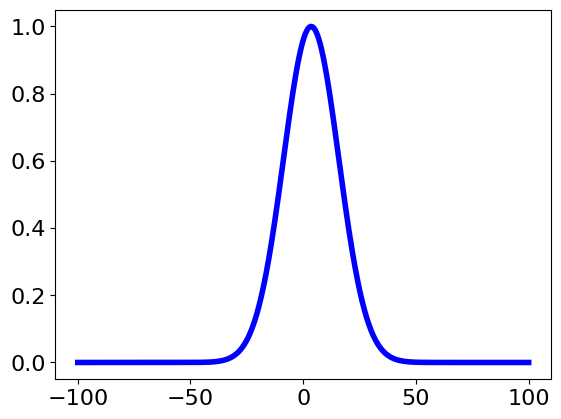

In [266]:
fig, ax = plt.subplots()
# ax.hist(df_fluka_mpwc.X, bins=100);

y_gaussian = gaussian_function(x, 0, 1, np.mean(df_fluka_mpwc.X), np.std(df_fluka_mpwc.X))
ax.plot(x, y_gaussian/y_gaussian.max(), c="b", ls="-", lw=4, label=f"MWPC H FWHM = {fwhm_func(popt[3]):.1f} mm")


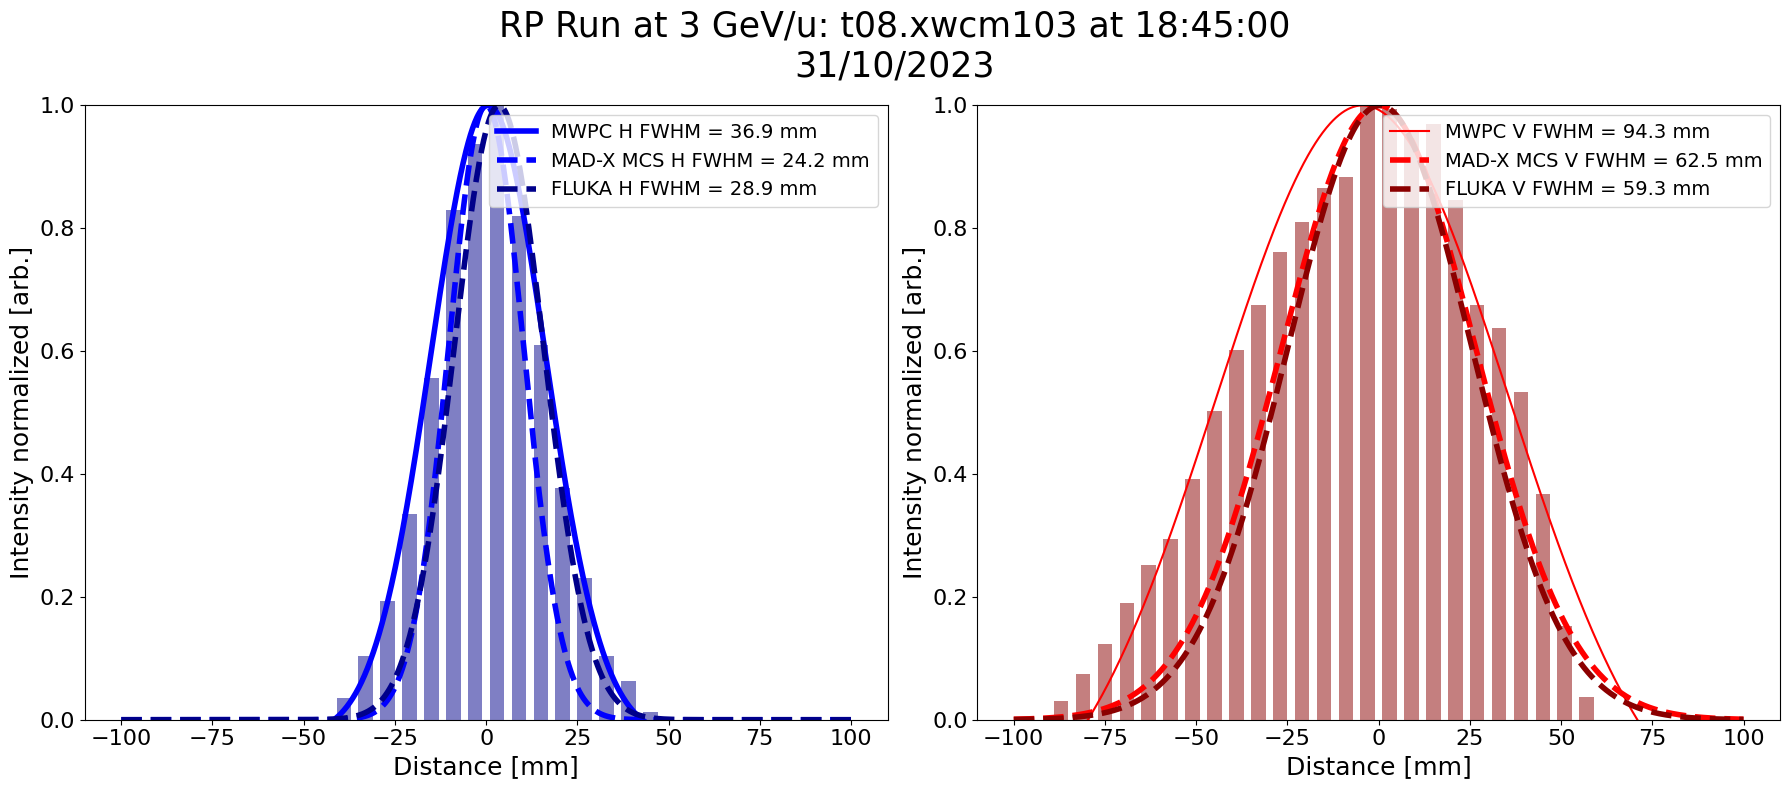

In [267]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit

fig, ax = plt.subplots(1,2, figsize=(18, 8), tight_layout=True)

target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)
x = np.linspace(-0.1*1000, 0.1*1000, 1000)

# Horizontal Measurement and Gaussian Fit
y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
ax[0].bar(MWPC_wire, y/y.max(), width=4, color="darkblue", alpha=0.5)

popt, pcov = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(x, popt[0], popt[1], popt[2], popt[3])
ax[0].plot(x, y_gaussian/y_gaussian.max(), c="b", ls="-", lw=4, label=f"MWPC H FWHM = {fwhm_func(popt[3]):.1f} mm")

# Vertical Measurement and Gaussian Fit
y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
ax[1].bar(MWPC_wire, y/y.max(), width=4, color="darkred", lw=4, alpha=0.5)
poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
ax[1].plot(x, y_gaussian/y_gaussian.max(), c="r", ls="-", label=f"MWPC V FWHM = {fwhm_func(poptV[3]):.1f} mm")

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

# MAD-X
# observation = "t08.btv096"
observation = "t08.xwcm103"
sigH = beam_size(twiss_scattered.loc[observation]['betx'], twiss_scattered.loc[observation]['dx'], twiss_scattered.loc[observation].ex, sige, 1)
sigV = beam_size(twiss_scattered.loc[observation]['bety'], twiss_scattered.loc[observation]['dy'], twiss_scattered.loc[observation].ey, sige, 1)
ax[0].plot(x, gaussian_function(x, 0, 1, 0, sigH*1000)/gaussian_function(x, 0, 1, 0, sigH*1000).max(), lw=4, ls="--", c="b", label=f"MAD-X MCS H FWHM = {fwhm_func(sigH)*1000:.1f} mm")
ax[1].plot(x, gaussian_function(x, 0, 1, 0, sigV*1000)/gaussian_function(x, 0, 1, 0, sigV*1000).max(), lw=4, ls="--", c="r", label=f"MAD-X MCS V FWHM = {fwhm_func(sigV)*1000:.1f} mm")


# FLUKA
y_gaussian = gaussian_function(x, 0, 1, np.mean(df_fluka_mpwc.X), np.std(df_fluka_mpwc.X))
ax[0].plot(x, y_gaussian/y_gaussian.max(), c="darkblue", ls="--", lw=4, label=f"FLUKA H FWHM = {fwhm_func(np.std(df_fluka_mpwc.X)):.1f} mm")

y_gaussian = gaussian_function(x, 0, 1, np.mean(df_fluka_mpwc.Y), np.std(df_fluka_mpwc.Y))
ax[1].plot(x, y_gaussian/y_gaussian.max(), c="darkred", ls="--", lw=4, label=f"FLUKA V FWHM = {fwhm_func(np.std(df_fluka_mpwc.Y)):.1f} mm")

# Decoration
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

ax[0].set_ylabel("Intensity normalized [arb.]")
ax[1].set_ylabel("Intensity normalized [arb.]")

ax[0].set_xlabel("Distance [mm]")
ax[1].set_xlabel("Distance [mm]")

fig.suptitle(f"RP Run at 3 GeV/u: {observation} at {data[data.selector == selector].timestamp.loc[element].strftime('%H:%M:%S')}\n{data[data.selector == selector].timestamp.loc[element].strftime('%d/%m/%Y')}", fontsize=25)
plt.savefig("3d_mwpc.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

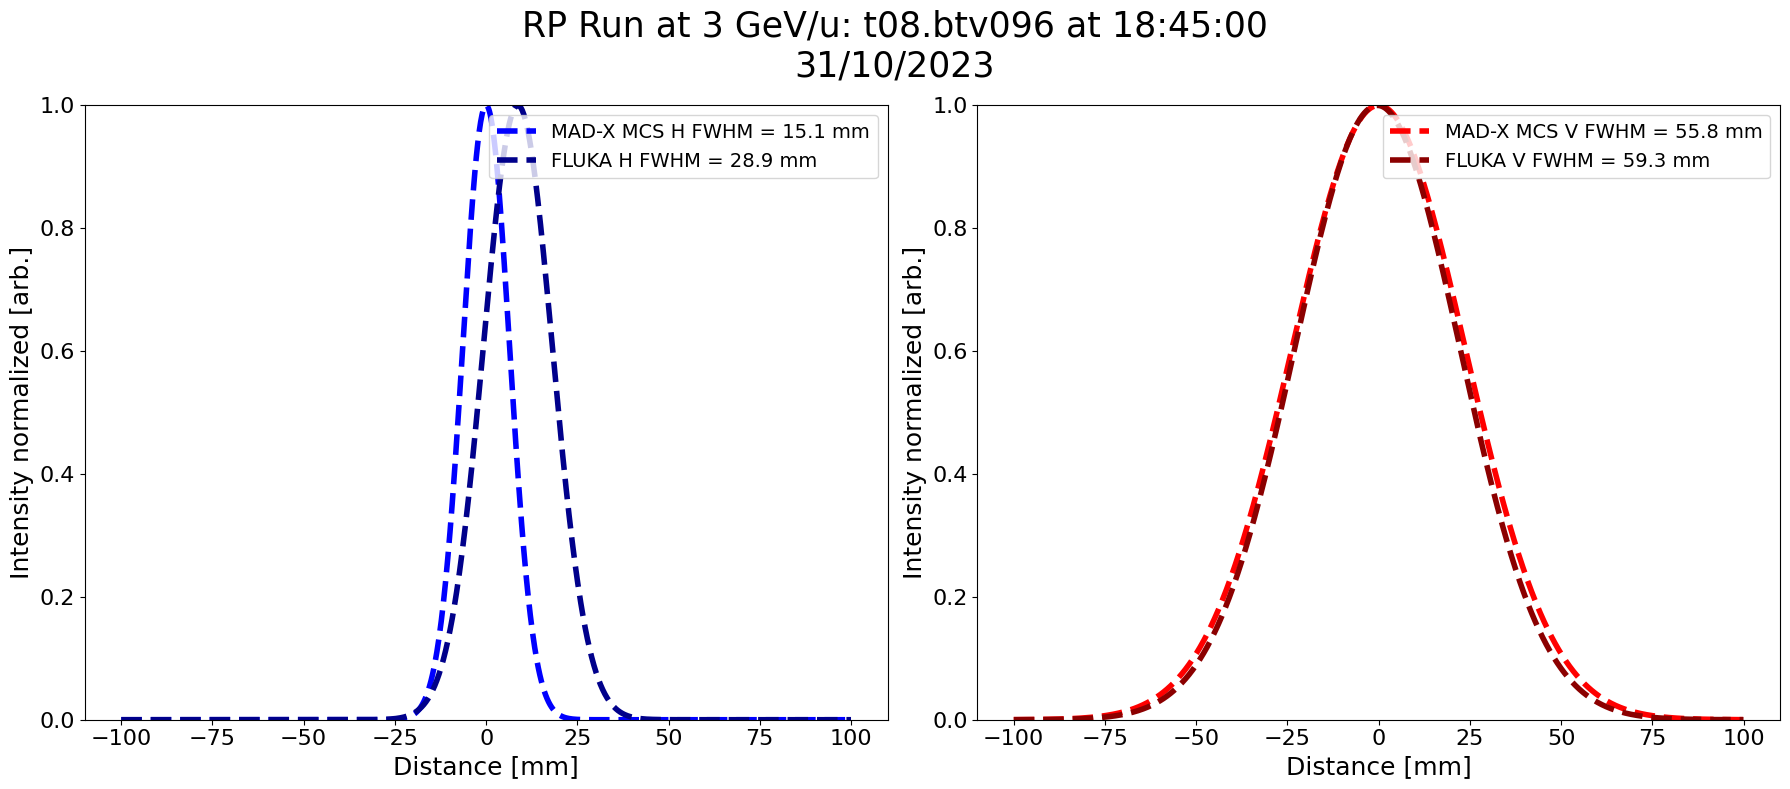

In [268]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit

fig, ax = plt.subplots(1,2, figsize=(18, 8), tight_layout=True)

target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)
x = np.linspace(-0.1*1000, 0.1*1000, 1000)

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

# MAD-X
observation = "t08.btv096"
# observation = "t08.xwcm103"
sigH = beam_size(twiss_scattered.loc[observation]['betx'], twiss_scattered.loc[observation]['dx'], twiss_scattered.loc[observation].ex, sige, 1)
sigV = beam_size(twiss_scattered.loc[observation]['bety'], twiss_scattered.loc[observation]['dy'], twiss_scattered.loc[observation].ey, sige, 1)
ax[0].plot(x, gaussian_function(x, 0, 1, 0, sigH*1000)/gaussian_function(x, 0, 1, 0, sigH*1000).max(), lw=4, ls="--", c="b", label=f"MAD-X MCS H FWHM = {fwhm_func(sigH)*1000:.1f} mm")
ax[1].plot(x, gaussian_function(x, 0, 1, 0, sigV*1000)/gaussian_function(x, 0, 1, 0, sigV*1000).max(), lw=4, ls="--", c="r", label=f"MAD-X MCS V FWHM = {fwhm_func(sigV)*1000:.1f} mm")

# FLUKA
y_gaussian = gaussian_function(x, 0, 1, np.mean(df_fluka_target.X), np.std(df_fluka_target.X))
ax[0].plot(x, y_gaussian/y_gaussian.max(), c="darkblue", ls="--", lw=4, label=f"FLUKA H FWHM = {fwhm_func(np.std(df_fluka_mpwc.X)):.1f} mm")

y_gaussian = gaussian_function(x, 0, 1, np.mean(df_fluka_target.Y), np.std(df_fluka_target.Y))
ax[1].plot(x, y_gaussian/y_gaussian.max(), c="darkred", ls="--", lw=4, label=f"FLUKA V FWHM = {fwhm_func(np.std(df_fluka_mpwc.Y)):.1f} mm")


ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

ax[0].set_ylabel("Intensity normalized [arb.]")
ax[1].set_ylabel("Intensity normalized [arb.]")

ax[0].set_xlabel("Distance [mm]")
ax[1].set_xlabel("Distance [mm]")

fig.suptitle(f"RP Run at 3 GeV/u: {observation} at {data[data.selector == selector].timestamp.loc[element].strftime('%H:%M:%S')}\n{data[data.selector == selector].timestamp.loc[element].strftime('%d/%m/%Y')}", fontsize=25)
plt.savefig("3d_mwpc.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')